#### This is a supervised learning exercise for CU Boulder master's program in Data Science

## 0 Modules 

In [183]:
# Import Variables

import os
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import random
import openpyxl
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc


## 1.0 Introduction

- **Project Topic** - This project attempts to predict customer churn for a streaming service provider.
- **Project Goal** - The goal is to predict which customers are about to churn (about to cancel their subscription) so that the service provider can intervene to prevent churn (i.e. offer a promotion or discount). This is a common problem for companies to prevent customer churn. 
- **Table of Contents**  
  2. data
  3. data cleaning
  4. exploratory data analysis (EDA)
  5. feature engineering
  6. models
  7. results & analysis
  8. discussion & conclusion
- **Model** - I test various models and end up using a **random forest model**. See more in "models" section.
- **Task** - This problem is a binary classifier in which positive (1) is churn and (2) is not churn. See more in "models" section

## 2.0 Data

#### 2.1 Data Source
- The data is from an undisclosed streaming service provider
- The data is propriety data and cannot be disclosed publicly

#### 2.2 Data Structure
- The data is from May 2023 to August 2023
- The data exists at 2 levels: accounts & streaming sessions

#### 2.3 Loading the Data & Schema

In [184]:
# Open "accounts.csv" and "streams.csv" into DataFrames
accounts_df = pd.read_csv('user_accounts.csv')
streams_df = pd.read_csv("user_streams.csv")

#### 2.4 Viewing Schema

In [185]:
# Display the resulting DataFrames
pd.set_option('display.max_colwidth', 20)
print(accounts_df.sample(10))
print("\n")
print(streams_df.sample(10))

          account_number  price  churned
496  e078af3026edb42c...  30.56        1
477  5a39cadd1b007093...  12.62        0
971  683d098205b11550...  35.19        0
195  09895de0407bcb03...  30.56        1
649  826e27285307a923...  36.90        1
499  7104741a92e73eb6...  25.16        1
642  9be3da431e0a833d...  32.05        1
696  d40fbd13d527595c...  10.83        0
304  9400f1b21cb527d7...  26.58        0
212  39bb88f40d3aa2b2...  21.40        0


             account_number      start_timestamp        end_timestamp  \
95221   477f4b2cdd3fe2b9...  2023-05-10 00:26...  2023-05-10 00:26...   
226892  bc57590a33fe355e...  2023-06-08 21:14...  2023-06-08 21:19...   
88054   3963317a2b410e53...  2023-05-01 02:14...  2023-05-01 02:21...   
237118  1de4842b42fa3db3...  2023-07-30 02:12...  2023-07-30 02:13...   
14304   afa472a961fbcb09...  2023-05-26 10:37...  2023-05-26 10:39...   
144582  ee62de25ccc2b55d...  2023-05-31 08:52...  2023-05-31 08:52...   
28110   09eac95eb995b821...  2023-06

#### 2.5 Data Records

In [186]:
# Total Records
print(
    f"records in streams_df: {len(streams_df)}", 
    f"records in accounts_df: {len(accounts_df)}",
    sep = "\n"
    )

records in streams_df: 325300
records in accounts_df: 1000


#### 2.6 Features & Descriptions
- There are 5 features existing across 2 tables ```streams``` & ```accounts```:
  - ```account_number``` - Unique Identifier for Customer
  - ```mean_opinion_score_value``` - A measure of stream quality from 0 to 5
  - ```start_timestamp``` - Start timestamp of streaming session
  - ```end_timestamp``` - End timestamp of streaming session
  - ```price``` - Monthly Subscription Price
  - ```churned``` - Dummy Variable if Customer Churned


## 3 Data Cleaning

#### 3.1 Summary
- **Why Cleaning** - we take following steps below
  - Converting Datatypes: We convert our timestamps from string to ```pd.datetime``` so we can build features on this. This is necessary for the feature extraction phase.
  - Removing Duplicates: A very small number of rows were duplicates (<30). We remove them. This could skew the data.
  - Missing Window in Timestamps: There is missing data across 20% of days. We note this.
  - Drop Users - We drop users in which 20% of their start timestamp is missing. This is only 2% of records. It is better to drop these than impute values b/c it is small percentage and it is unclear what the underlying NAs really mean.
  - Join Quality - We notice that we only have session data on ~50% of users listed in accounts table. It is unclear if the data is bad or users never had a session.
  - Outliers - We remove outliers of session duration (i.e. > 1 day session length). This was only a dozen or so records. These outliers could make our model not perform well.
  - Bad Data - We remove a record with negative session time. A negative time is not possible and is an outlier that could affect results of our model
- **Conclusions**
  - Quality of Data - There is issues (noted above with the data). The data quality does not appear to be the greatest and there are open questions on how to interpret the data. Nonetheless after cleaning the data it is suitable for prediction.
  - Cleaning of data - We take many steps (noted above) to lean the data. This data is now ready for models as we removed major outliers and NAs. 
- **Visualization** - I have produced various visualizations, namely a histogram of NAs and a linechart of missing timestamps (see charts in section. Furthermore there are many histograms in EDA section which relate to ensuring data is quality.

#### 3.2 View Columns

In [187]:
print("streams_df", *streams_df.columns, sep="\n")
print("")
print("accounts_df", *accounts_df.columns, sep = "\n")

streams_df
account_number
start_timestamp
end_timestamp
mean_opinion_score_value

accounts_df
account_number
price
churned


#### 3.3 Convert string to Timestamp

In [188]:
streams_df['start_timestamp'] = pd.to_datetime(streams_df['start_timestamp'])
streams_df['end_timestamp'] = pd.to_datetime(streams_df['end_timestamp'])

#### 3.4 Missing Values

In [189]:
def count_print_summary(df):
    # Count rows that are all NA
    count_all_na = df.isnull().all(axis=1).sum()
    print(f"{count_all_na} - All NA rows")

    # Count rows with any NA
    count_any_na = df.isnull().any(axis=1).sum()
    print(f"{count_any_na} - Any NA rows")

    # Count duplicate rows
    count_duplicates = df.duplicated().sum()
    print(f"{count_duplicates} - Duplicate rows")

# Example usage
count_print_summary(streams_df)


0 - All NA rows
16829 - Any NA rows
24 - Duplicate rows


#### 3.5 Column by Column NAs

In [190]:
# Inspect NAs

print(
    streams_df.dtypes,
    streams_df.isnull().sum(), 
    accounts_df.dtypes,
    accounts_df.isnull().sum(), sep = "\n\n"
)

# Insight - NAs for start_timestamp & mos_score. Otherwise data & dtypes good.

account_number                      object
start_timestamp             datetime64[ns]
end_timestamp               datetime64[ns]
mean_opinion_score_value           float64
dtype: object

account_number                  0
start_timestamp              6044
end_timestamp                   0
mean_opinion_score_value    16676
dtype: int64

account_number     object
price             float64
churned             int64
dtype: object

account_number    0
price             0
churned           0
dtype: int64


#### 3.6 Confirm Data Duration

In [191]:
print(
    f"{round((streams_df.start_timestamp.max() - streams_df.start_timestamp.min()).total_seconds()/60/60/24)} days of data",
    f"from:  {streams_df.start_timestamp.min().date()}",
    f"to:    {streams_df.start_timestamp.max().date()}",
    sep = "\n"
    )

116 days of data
from:  2023-04-29
to:    2023-08-23


#### 3.7 Visualize Missing Data

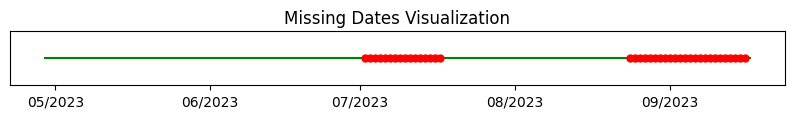

('min_date is: 2023-04-29', 'max_date is: 2023-09-17')

In [192]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def get_missing_dates(df: pd.DataFrame, column_name: str) -> tuple[str, str]:

    # Get the range of dates
    min_date = df[column_name].min().date()
    max_date = df[column_name].max().date()

    # Generate the date range
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Filter the DataFrame for the dates in the range
    filtered_df = df[df[column_name].dt.date.isin(date_range.date)]

    # Identify missing dates
    missing_dates = set(date_range.date) - set(filtered_df[column_name].dt.date)

    # Visualize the missing dates
    fig, ax = plt.subplots(figsize=(10, .7))
    ax.plot(date_range, [1] * len(date_range), 'g-', label='Existing Dates')
    ax.plot(list(missing_dates), [1] * len(missing_dates), 'r.', markersize=10, label='Missing Dates')
    ax.set_yticks([])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    ax.set_title('Missing Dates Visualization')

    plt.show()
    
    return f"min_date is: {min_date}", f"max_date is: {max_date}", #missing_dates

get_missing_dates(streams_df, 'end_timestamp')


#### 3.8 Inspect Duplicate

In [193]:
# Inspect duplicates

print(
    f"row duplicates in streams_df: {sum(streams_df.duplicated())}",
    f"row duplicates in accounts_df: {sum(accounts_df.duplicated())}",
    sep = "\n"
)

print(f"column duplicates for end_timestamp: {sum(streams_df.end_timestamp.duplicated())}")

row duplicates in streams_df: 24
row duplicates in accounts_df: 0
column duplicates for end_timestamp: 54


#### 3.9 Remove Duplicates

In [194]:
def remove_duplicates(df):
    #print("Duplicate Rows:")
    #print(df[df.duplicated()])
    
    old_len = len(df)
    df.drop_duplicates(inplace=True)
    new_len = len(df)
    
    print(f"Number of Rows Removed: {old_len - new_len}")
    
    
    return df

streams_df = remove_duplicates(streams_df)

Number of Rows Removed: 24


#### 3.10 Drop Problematic Accounts

Dropped following users: ['98964da49d0a98402ed3d2d37b3350cf0aa346f522f8f1feb6b01cd680bc9455', 'd6723fa996ced47773f2dea29cce9b11f951e6dafe321a84ac7d32791c3b4660', 'a917ca757ac59f9d568616140c2f72362fc2722ab277e7b5019008f280f17beb', 'a807c0dc0a5b5ea4a70b12ba52ead3d30922e1eac15c396ccfdea715a2f15396', '8ae4c23b80d1e7c8ff79e515fe791ebd68190bae842dda7af193db125f700452']
Dropped 5389 rows which was 2.0%


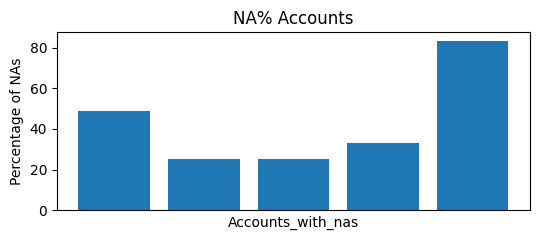

,account_number,price,churned
128,a917ca757ac59f9d...,30.56,1
300,8ae4c23b80d1e7c8...,33.64,1
364,98964da49d0a9840...,36.90,0
589,a807c0dc0a5b5ea4...,30.56,0
590,d6723fa996ced477...,12.04,1


In [195]:
# Remove problematic NA accounts


def drop_na_users(df: pd.DataFrame, column_names: list, percent_threshold: float, verbose: bool = True) -> pd.DataFrame:
    '''
    Drop users with a certain percentage of NA's across different column names
    '''

    filtered_users = []

    for column_name in column_names:
        # Count of null values by user
        null_counts = df[df[column_name].isnull()].groupby('account_number').size()

        # Count of rows by user
        total_counts = df.groupby('account_number').size()

        # Calculate percentages
        percentages = (null_counts / total_counts) * 100

        # Filter out users based on percentage threshold
        filtered_users.extend(percentages[percentages >= percent_threshold].index.tolist())

    # Remove duplicates from filtered_users
    filtered_users = list(set(filtered_users))

    # Remove users and rows with any null value
    result = df[~df['account_number'].isin(filtered_users)]

    if verbose:
        print(f"Dropped following users: {filtered_users}")
        old_n = len(df)
        new_n = len(result)
        print(f"Dropped {old_n-new_n} rows which was {round((old_n-new_n)/old_n, 2) * 100}%")

    # Visualize the users being removed
    na_percentages = [percentages.loc[user] for user in filtered_users]
    fig, ax = plt.subplots(figsize=(5.5, 2.5))
    ax.bar(range(len(filtered_users)), na_percentages)
    ax.set_xticks(range(len(filtered_users)))
    ax.set_xticklabels(filtered_users, rotation='vertical')

    ax.set_ylabel('Percentage of NAs')
    ax.set_xlabel('Accounts_with_nas')
    plt.xticks([]) # remove labels
    ax.set_title('NA% Accounts')
    plt.tight_layout()
    plt.show()

    return result, filtered_users

streams_df, filtered_users = drop_na_users(streams_df, ["start_timestamp"], 20)

accounts_df[accounts_df.account_number.isin(filtered_users)]

#### 3.11 Examine LEFT & RIGHT Join Relationships

In [196]:
# examine join relationship

account_users = set(accounts_df.account_number)
stream_users = set(streams_df.account_number)
print(\
f"total users = {len(account_users.union(stream_users))}",
f"intersection = {len(account_users.intersection(stream_users))}",
f"users only in account = {len(account_users.difference(stream_users))}",
f"users only in streams = {len(stream_users.difference(account_users))}", sep = "\n"
)

total users = 1000
intersection = 541
users only in account = 459
users only in streams = 0


#### 3.12 Add Duration Feature (to detect outliers)

In [197]:
# Subtract the two timestamp columns and convert to timedelta
streams_df['duration_seconds'] = (streams_df['end_timestamp'] - streams_df['start_timestamp']).dt.total_seconds()

#### 3.13 Detect & Remove Outliers

In [198]:
def detect_and_remove_outliers(df, columns, z_score_threshold, remove_outliers=False):
    mask = pd.Series(True, index=df.index)
    
    for column in columns:
        column_data = df[column]
        z_scores = (column_data - column_data.mean()) / column_data.std()
        is_outlier = np.abs(z_scores) > z_score_threshold
        outliers = df[is_outlier][["account_number"]+columns]

        if not outliers.empty:
            outliers_z_scores = pd.DataFrame({'Z Score': z_scores[is_outlier]}, index=outliers.index)
            outliers = pd.concat([outliers, outliers_z_scores], axis=1)

            print(f"Outliers in column '{column}':\n")
            print(round(outliers.sort_values("Z Score")))
        
        if remove_outliers:
            mask &= ~is_outlier

    if remove_outliers:
        df = df[mask]

    return df
streams_df = detect_and_remove_outliers(streams_df, ["duration_seconds"], 14, remove_outliers = True)

Outliers in column 'duration_seconds':

             account_number  duration_seconds  Z Score
203567  14063697603e22d6...          639271.0     99.0
135117  d48ff4b2f68a10fd...         1717080.0    266.0
306705  da70dfa4d9f95ac9...         2925841.0    454.0


#### 3.14 Remove Odd Durations

In [199]:
# Filter bad data (negative duration streams and too long streams)

def filter_stream_duration(df: pd.DataFrame, col:str, verbose: bool = True):
    # create indexes
    index_negative = streams_df[col] < 0
    
    if verbose:
        print(f"records with negative duration - {sum(index_negative)}")
        print(df[index_negative][["account_number","duration_seconds"]])

    return(df[-index_negative]) # bitwise operator - record must be TRUE & TRUE to keep   
    
streams_df = filter_stream_duration(streams_df, "duration_seconds") 

records with negative duration - 1
             account_number  duration_seconds
200601  5538e771949ffec1...         -3550.886


## 4.0 exploratory data analysis (EDA)

**Summary**
 - **Histgorams** - We look at histograms of major features to ensure distributions are expected without major outliers
 - **Feature Importance** - We plot feature importance in the ```Results & Analysis``` Section
 - **Correlation Matrix** - We do not use a correlation matrix because the features were too few to justify this
 - **Findings** - Findings are discussed in each respective section. In summary the data is limited, and there are many sessions with very short durations. This is concerning. Otherwise data shows some expected trends for streaming data

#### 4.1 - Univariate Analysis ```mean_opinion_score_value```
- Score Range - We see expected distribution. Most scores are near 5 (which is perfect score)
- Plots - We plot 0 to 5, but also plot 3.5 to 5 which is the range where most values lie.

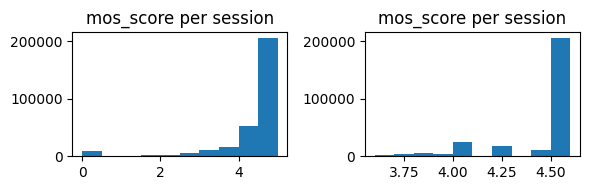

4.595744680851064


In [200]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = streams_df.sort_values(by="mean_opinion_score_value")

# Create a single subplot
fig, ax = plt.subplots(1,2,figsize=(6, 2))

# Plot the histogram with range 2000
ax[1].hist(df['mean_opinion_score_value'], bins=10, range=[3.6,4.6])
ax[1].set_title('mos_score per session')

ax[0].hist(df['mean_opinion_score_value'], bins=10, range=[0, 5])
ax[0].set_title('mos_score per session')
# Display the plot
plt.tight_layout()
plt.show()
print(streams_df.mean_opinion_score_value.max())


#### 4.2 - Univariate Analysis ```account_number```
- Here we sort accounts with most sessions to see if there are serious outliers
- Most accounts have less than 50 sessions
- Some "power uses" have hundreds of sessions

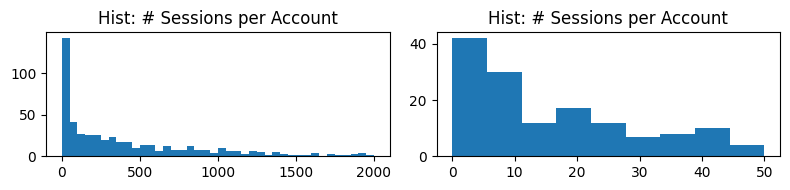

In [201]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = streams_df.groupby("account_number").count().sort_values(by="end_timestamp")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

# Plot the first histogram with range 2000
axes[0].hist(df['end_timestamp'], bins=40, range=(0, 2000))
axes[0].set_title('Hist: # Sessions per Account')

# Plot the second histogram with range 10
axes[1].hist(df['end_timestamp'], bins="auto", range=(0, 50))
axes[1].set_title('Hist: # Sessions per Account')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


#### 4.3 - Univariate Analysis ```Price```
- 30 dollar average - We see no outliers. Price is expected at 30 or so dollars per user
- Subsidy - Many users pay less than 15 dollars which are likely subsidized users

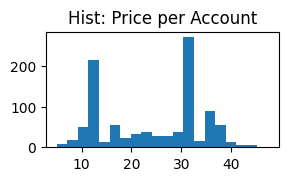

In [202]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = accounts_df.sort_values(by="price")

# Create a single subplot
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the histogram with range 2000
ax.hist(df['price'], bins=20)
ax.set_title('Hist: Price per Account')

# Display the plot
plt.show()


#### 4.4 - Univariate Analysis ```duration```
- Data Quality - Most sessions are <200 seconds. This suggests many users log in and off very quickly. This might be a data quality issue
- By User is Normal - Sessions (by user) shows a more normal curve (excluding outliers). We see many sessions lasting ~1400 seconds which is 20 or so minutes which is expected.

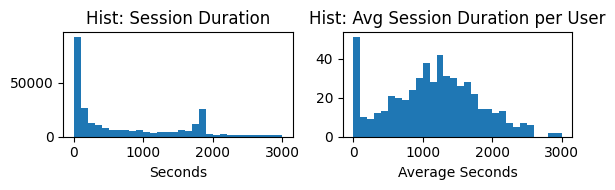

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = streams_df.groupby("account_number").mean(numeric_only=True).sort_values(by="duration_seconds")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 2))

# Plot the first histogram with range 2000
axes[1].hist(df['duration_seconds'], bins=30, range=(0, 3000))
axes[1].set_title('Hist: Avg Session Duration per User')
axes[1].set_xlabel('Average Seconds')
# Plot the second histogram with range 10
axes[0].hist(streams_df['duration_seconds'], bins=30, range=(0, 3000))
axes[0].set_title('Hist: Session Duration')
axes[0].set_xlabel('Seconds')
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## 5.0 Feature Engineering

#### 5.1 Create Sinusoidal Features

In [204]:

def create_sinusoidal_features(df, timestamp_column, prefix = ""):
    # Extract hour and day of the week from the timestamp column
    hours = df[timestamp_column].dt.hour
    days_of_week = df[timestamp_column].dt.dayofweek

    # Perform sinusoidal transformation for hour of the day
    df[f'{prefix}_hour_sin'] = np.sin(2 * np.pi * hours / 24)
    df[f'{prefix}_hour_cos'] = np.cos(2 * np.pi * hours / 24)

    # Perform sinusoidal transformation for day of the week
    df[f'{prefix}_day_of_week_sin'] = np.sin(2 * np.pi * days_of_week / 7)
    df[f'{prefix}_day_of_week_cos'] = np.cos(2 * np.pi * days_of_week / 7)

    return df

streams_df = create_sinusoidal_features(streams_df, "start_timestamp", "start")
streams_df = create_sinusoidal_features(streams_df, "end_timestamp", "end")

#### 5.2 Add Dummy Variables

In [205]:
# add binary / dummy variables expected of high signal

streams_df["mos_score_zero"] = streams_df.mean_opinion_score_value == 0
streams_df["duration_less_5_min"] = streams_df.duration_seconds < 60*5 # 5 min
streams_df["duration_less_1_min"] = streams_df.duration_seconds < 60   # 1 min
streams_df["mos_less_4_5"] = streams_df.mean_opinion_score_value < 4.5   
streams_df["mos_less_4_0"] = streams_df.mean_opinion_score_value < 4   

#### 5.3 Aggregation Features (Top 5 Sessions)

In [206]:
streams_df.reset_index(inplace= True)

In [207]:
# import pandas as pd

# def aggregate_last_n_streams(df, aggregation_dict, n=5, prefix='top_n_'):
#     # Get the indices of the last n streams for each account number
#     index_top_n = df.groupby('account_number')['end_timestamp'].nlargest(n).index.get_level_values(1)

#     # Select the columns to be aggregated
#     columns_to_aggregate = list(aggregation_dict.keys())

#     # Roll up the DataFrame by account and apply the aggregations
#     rolled_up_df = df.iloc[index_top_n].groupby('account_number', dropna=False)[columns_to_aggregate].agg(aggregation_dict)

#     # Flatten the column names
#     rolled_up_df.columns = rolled_up_df.columns.map('_'.join)

#     # Reset the index to make 'account_number' a regular column
#     rolled_up_df.reset_index(inplace=True)

#     # Add the prefix to the column names
#     rolled_up_df.columns = [prefix + col if col != 'account_number' else col for col in rolled_up_df.columns]

#     return rolled_up_df


# aggregation_dict_top_n = {
#     'duration_seconds': ['max', 'mean', 'min', 'median', 'count'],
#     'mean_opinion_score_value': ['max', 'mean', 'min', 'median'],
#     'mos_score_zero': ['sum'],
#     'duration_less_5_min': ['sum'],
#     'mos_less_4_5': ['sum'],
#     'mos_less_4_0': ['sum']
# }

# rolled_up_df_top_n = aggregate_last_n_streams(streams_df, aggregation_dict_top_n, n=5, prefix='top_5_')

#### 5.4 Aggregation Features (Mean, Max, Min, Median, Count)

In [208]:
# Aggregate last 5 stream DF

index_top_5 = streams_df.groupby('account_number').end_timestamp.nlargest(5).index.get_level_values(1)

aggregation_dict_top_n = {
    'duration_seconds': ['max', 'mean', 'min', 'median','count'],
    'mean_opinion_score_value': ['max', 'mean', 'min', 'median'],
    'mos_score_zero': ['sum'],
    'duration_less_5_min':['sum'],
    'duration_less_5_min':['sum'],
    'mos_less_4_5':['sum'],
    'mos_less_4_0':['sum']
}


columns_to_aggregate = list(aggregation_dict_top_n.keys())

# Roll up the DataFrame by account and apply the aggregations
rolled_up_df_top_n = streams_df.iloc[index_top_5].groupby('account_number', dropna = False)[columns_to_aggregate].agg(aggregation_dict_top_n)

# Flatten the column names
rolled_up_df_top_n.columns = rolled_up_df_top_n.columns.map('_'.join)

# Reset the index to make 'account_number' a regular column
rolled_up_df_top_n.reset_index(inplace=True)

# Define the suffix to be added
prefix = 'top_5_'

# Loop through each column in the DataFrame
for column in rolled_up_df_top_n.columns:
    
    if column != "account_number":
    # Add the suffix to the column name
        new_column = prefix + column 
    
    # Update the column name in the DataFrame
        rolled_up_df_top_n.rename(columns={column: new_column}, inplace=True)

#### 5.4 Aggregation Features

In [209]:

# Define the aggregation functions and new column names
aggregation_dict = {
    'start_timestamp': 'min',
    'end_timestamp': ['max', 'mean', 'count'],
    'duration_seconds': ['max', 'mean', 'min', 'median','count'],
    'mean_opinion_score_value': ['count', 'max', 'mean', 'min', 'median'],
    'start_hour_sin': 'mean',
    'end_hour_sin': 'mean',
    'start_hour_cos': 'mean',
    'end_hour_cos': 'mean',
    'start_day_of_week_sin': 'mean',
    'end_day_of_week_sin': 'mean',
    'start_day_of_week_cos': 'mean',
    'end_day_of_week_cos': 'mean',
    'mos_score_zero': ['sum'],
    'duration_less_5_min':['sum'],
    'duration_less_5_min':['sum'],
    'mos_less_4_5':['sum'],
    'mos_less_4_0':['sum']
}


columns_to_aggregate = list(aggregation_dict.keys())

# Roll up the DataFrame by account and apply the aggregations
partial_rolled_up_df = streams_df.groupby('account_number', dropna = False)[columns_to_aggregate]

rolled_up_df = partial_rolled_up_df.agg(aggregation_dict)

# Flatten the column names
rolled_up_df.columns = rolled_up_df.columns.map('_'.join)

# Reset the index to make 'account_number' a regular column
rolled_up_df.reset_index(inplace=True)


#### 5.5 Merge Features & Target

In [210]:
rolled_up_df = pd.merge(rolled_up_df, rolled_up_df_top_n, on="account_number", how = "outer")
merged_df = pd.merge(rolled_up_df, accounts_df, how='outer', on = "account_number")

In [211]:
# rolled_up_df["percent_na_mos_score"] = rolled_up_df.mos_score_count / rolled_up_df.end_timestamp_count 
# rolled_up_df["tail_end_moss_difference"] = rolled_up_df["mos_score_mean"] - rolled_up_df["top_5_mos_score_mean"]

#### 5.6 Add Additional Timestamp Features

In [212]:
merged_df['duration_first_to_last'] = (merged_df.end_timestamp_max - merged_df.start_timestamp_min).dt.total_seconds()

# Get the maximum and minimum values of the timestamp column
max_timestamp = merged_df['end_timestamp_mean'].max()
min_timestamp = merged_df['end_timestamp_mean'].min()

# Calculate the time range
time_range = max_timestamp - min_timestamp

# Standardize the timestamp column from 0 to 1
merged_df['end_timestamp_mean'] = (merged_df['end_timestamp_mean'] - min_timestamp) / time_range

# Drop max and min
merged_df.drop(columns=['end_timestamp_max', 'start_timestamp_min'], inplace=True)


## 6.0 Models
**Summary**
- Model Choice: Random Forest
- Collinearity Conditions - Generally collinearity of features is not a problem for Random Forest. Therefore Our approach is to twist and construe many features and test them all in the model to see which features are important
- Interactions - Since we had few features we don't test particular interaction terms. We do however test dummy variables at key points where we believe there are signal to help the model find the signal.
- Model Testing - I test a variety of models (see section 6.1)
- Model Importance - I graph model importance for Random Forest
- Class Imbalance - There was no need to treat for imbalance because it was already pretty balanced, it is noted however that we optimized for recall
- Overfitting - Random forest is particularly robust against overfitting because of random sampling & random feature selection. Nonetheless I plot learning curve and see a convergence.

#### 6.1 Test Different Models
- Performance - Random Forest is top performer for recall
- Favorable Properties - Because of random forest robustness to overfit and simplicity we choose this model

In [214]:
merged_df.fillna(value=0, inplace=True)

In [215]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def run_classification(X, y, num_folds=4):
    # Create the individual classifiers
    svm_classifier = SVC()
    random_forest_classifier = RandomForestClassifier(
        n_estimators = 100,
        min_samples_split = 10, 
        min_samples_leaf = 5,
        max_depth=4,
        criterion="entropy", 
        class_weight="balanced",
        max_features=.5
    )
    naive_bayes_classifier = GaussianNB()
    logistic_regression = LogisticRegression(max_iter=1000, solver = "liblinear", penalty = 'l1')
    gradient_booster = GradientBoostingClassifier()
    xgb_classifier = XGBClassifier()
    #knn_classifier = KNeighborsClassifier()

    # Define a list of classifiers
    classifiers = [
        ('SVM', svm_classifier),
        ('Random Forest', random_forest_classifier),
        ('Naive Bayes', naive_bayes_classifier),
        ('Logistic Regression', logistic_regression),
        ('Gradient Boost', gradient_booster),
        ('XGBoost', xgb_classifier),
        #('KNN', knn_classifier)
    ]

    # Create stratified k-fold cross-validator
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random.randint(0, 100))

    model_performances = []

    # Train and evaluate each classifier using cross-validation
    for name, classifier in classifiers:
        accuracy_scores = []
        confusion_matrices = []
        precision_scores = []
        recall_scores = []

        for train_index, test_index in kfold.split(X, y):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
            classifier.fit(X=X_train_fold, y=y_train_fold)
            accuracy = classifier.score(X_test_fold, y_test_fold)
            accuracy_scores.append(accuracy)
            y_pred = classifier.predict(X_test_fold)
            confusion_matrices.append(confusion_matrix(y_test_fold, y_pred))
            precision_scores.append(precision_score(y_test_fold, y_pred))
            recall_scores.append(recall_score(y_test_fold, y_pred))

        avg_accuracy = np.mean(accuracy_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)

        model_performances.append([name, avg_accuracy, confusion_matrices, avg_precision, avg_recall])

    for x in sorted(model_performances, key=lambda x: x[1], reverse=True):
        print(f"{x[1]:.3f} Average Accuracy: {x[0]}")
        print("Confusion Matrix:")
        cf_summed = np.sum(x[2], axis=0)
        print(cf_summed)
        print(f"Precision: {x[3]:.3f}")
        print(f"Recall: {x[4]:.3f}")
        print()


# Example usage
X = merged_df.drop(columns=['churned','account_number'])
y = merged_df['churned']
run_classification(X, y,3)


0.806 Average Accuracy: Random Forest
Confusion Matrix:
[[424 163]
 [ 31 382]]
Precision: 0.701
Recall: 0.925

0.799 Average Accuracy: Gradient Boost
Confusion Matrix:
[[437 150]
 [ 51 362]]
Precision: 0.708
Recall: 0.876

0.792 Average Accuracy: XGBoost
Confusion Matrix:
[[447 140]
 [ 68 345]]
Precision: 0.713
Recall: 0.835

0.767 Average Accuracy: Logistic Regression
Confusion Matrix:
[[392 195]
 [ 38 375]]
Precision: 0.658
Recall: 0.908

0.754 Average Accuracy: SVM
Confusion Matrix:
[[375 212]
 [ 34 379]]
Precision: 0.641
Recall: 0.918

0.720 Average Accuracy: Naive Bayes
Confusion Matrix:
[[341 246]
 [ 34 379]]
Precision: 0.606
Recall: 0.918



#### 6.2 Feature Importance (Random Forest)

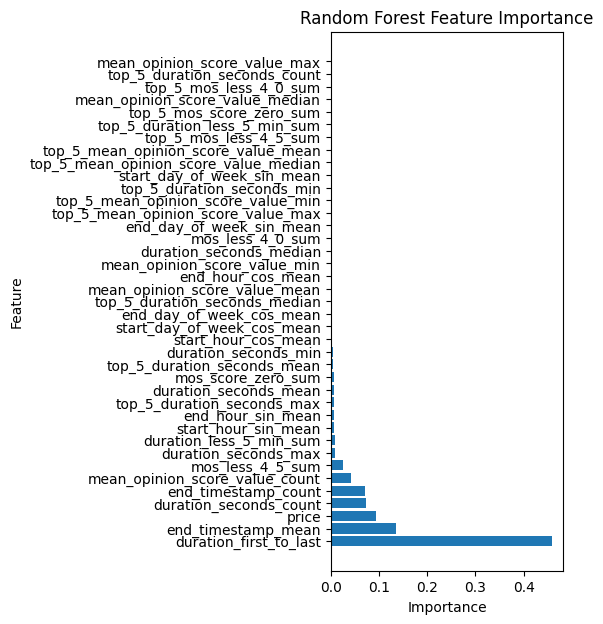

In [216]:
# Prepare the data
X = merged_df.drop(columns=['churned','account_number'])
y = merged_df['churned']

# Fit the random forest model
rf = RandomForestClassifier(
    n_estimators = 100,
    min_samples_split = 20, 
    min_samples_leaf = 5,
    max_depth=4,
    criterion="entropy", 
    class_weight={False:1,True:2},
    max_features=.5
)
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

# Create a dataframe of feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(3, 7))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()



#### 6.3 Class Imbalance
- Not significant class imbalance. There are roughly %60 of non churned

In [217]:
class_counts = accounts_df['churned'].value_counts()

print("Class Counts for 'churned' column:")
print(class_counts)

Class Counts for 'churned' column:
churned
0    587
1    413
Name: count, dtype: int64


## 7.0 Results & Analysis

#### 7.1 Summary
- **Results** -
  - Performance - We have achieved an 80% accuracy and 90% recall on the data.
  - Recall vs Precission - Generally with churn data we want to prioritize recall. There is a small class imbalane so it is better to focus on AUC & recall.
  - Data Quality Issues - Overall the results are good but there remains serious data quality issues
  - Data Leakage - The biggest issue is the structure of the data is not good. We only know if a customer churned, and not specifically when they churned. This means there is likely model leakage in the data. When a customer churns they no longer will have sessions. This is the critical problem in the data
  - Learning Curve - We need more data. It looks like testing accuracy is moving up to converge to training data, but b/c our samples are limited it is hard to know.
- **Visualizations** - See below for learning curve, ROC/AUC, and precision/recall/accuracy histogram on K fold training
- **Retraining** - We retrain model on top 10 features
  - Other Models - Next to other models random forest is top performaner in recall with good precision too (see results) 

#### 7.2 Learning Curve

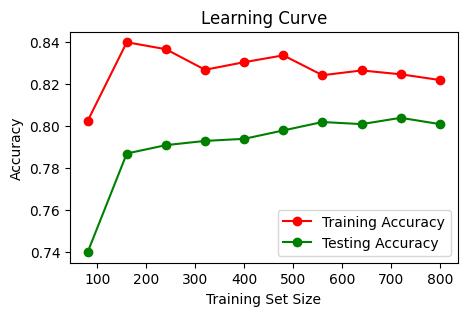

In [218]:

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate the average training and testing scores
avg_train_scores = np.mean(train_scores, axis=1)
avg_test_scores = np.mean(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(5, 3))
plt.plot(train_sizes, avg_train_scores, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, avg_test_scores, 'o-', color='g', label='Testing Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Make predictions on the testing data
y_pred = rf.predict(X)

# Get the probability estimates for each class
class_probabilities = rf.predict_proba(X)

#### 7.3 ROC/AUC Curve
- True positive rate (AKA recall) climbs sharply. We choose a threshold in which we get about 90% recall at the elbow area to prevent significant increase in False Positive Rate
- ROC under the curve is 88% which reflects good perfmance

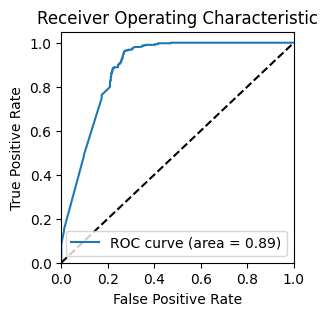

In [219]:
# Make predictions on the testing data
y_pred = rf.predict(X)

# Get the probability estimates for each class
class_probabilities = rf.predict_proba(X)
y_prob = class_probabilities[:, 1]

# Compute the false positive rate and true positive rate for the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### 7.4 Rerun Model Final Features
- We rerun the model with the select top 10 features with ~> 1% feature importance

In [220]:
feature_importances[0:10]

,Feature,Importance
38,duration_first_t...,0.459317
0,end_timestamp_mean,0.134531
37,price,0.094654
6,duration_seconds...,0.073103
1,end_timestamp_count,0.070923
7,mean_opinion_sco...,0.041352
22,mos_less_4_5_sum,0.026122
2,duration_seconds...,0.008322
21,duration_less_5_...,0.008166
12,start_hour_sin_mean,0.007258


#### 7.5 Rerunning the models on only Top Features
- Random forest gets great call and is top performer
- Naive Bayes also does well but has lower precision.
- This confirms that random forest is suitable model.
- Favorable properties of Random Forest:
  - Random forest is not significantly affected by outliers
  - Random forest doesn't need data normalized
  - Random forest doesn't have issues with collinearity
  - Random foest automatically can split on categorical & continuous variables 

In [221]:
important_columns = list(feature_importances[0:10].Feature)
X_2 = merged_df[important_columns]
y_2 = merged_df['churned']
run_classification(X_2, y_2,3)

0.807 Average Accuracy: Random Forest
Confusion Matrix:
[[421 166]
 [ 27 386]]
Precision: 0.700
Recall: 0.935

0.788 Average Accuracy: XGBoost
Confusion Matrix:
[[451 136]
 [ 76 337]]
Precision: 0.713
Recall: 0.816

0.783 Average Accuracy: Gradient Boost
Confusion Matrix:
[[431 156]
 [ 61 352]]
Precision: 0.694
Recall: 0.852

0.755 Average Accuracy: Logistic Regression
Confusion Matrix:
[[395 192]
 [ 53 360]]
Precision: 0.652
Recall: 0.872

0.752 Average Accuracy: SVM
Confusion Matrix:
[[373 214]
 [ 34 379]]
Precision: 0.639
Recall: 0.918

0.724 Average Accuracy: Naive Bayes
Confusion Matrix:
[[334 253]
 [ 23 390]]
Precision: 0.607
Recall: 0.944



#### 7.6 Precision, Recall & Accuracy Scores
- As discussed previously we are focused on high recall
- Below is 100 iterations of random data to see distributions of resulting precision, recall and accuracy
- We see significant variance which means we need more data

Average Accuracy: 0.801
Average Precision: 0.696
Average Recall: 0.927


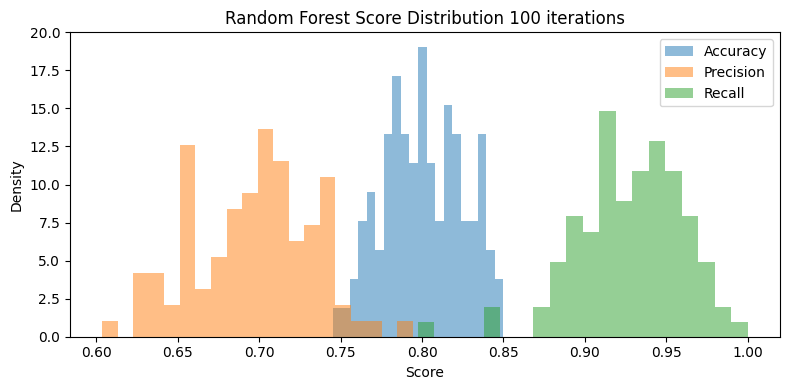

In [222]:

def run_random_forest(X, y, split=0.2, iterations=100, split_data=True):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    for i in range(iterations):
        # Perform train-test split if specified
        if split_data:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=i)
        else:
            X_train, X_test, y_train, y_test = X, None, y, None

        # Create and fit the Random Forest classifier
        rf_classifier = RandomForestClassifier(
            n_estimators = 100,
            min_samples_split = 10, 
            min_samples_leaf = 5,
            max_depth=5,
            criterion="entropy", 
            class_weight={False:1,True:2},
            max_features="sqrt"
        )
        rf_classifier.fit(X_train, y_train)

        # Make predictions on the test set or entire dataset
        if split_data:
            y_pred = rf_classifier.predict(X_test)
        else:
            y_pred = rf_classifier.predict(X_train)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred) if split_data else accuracy_score(y_train, y_pred)
        precision = precision_score(y_test, y_pred) if split_data else precision_score(y_train, y_pred)
        recall = recall_score(y_test, y_pred) if split_data else recall_score(y_train, y_pred)

        # Append scores to the lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Calculate average scores
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    # Print average scores
    print("Average Accuracy:", round(avg_accuracy, 3))
    print("Average Precision:", round(avg_precision, 3))
    print("Average Recall:", round(avg_recall, 3))

    # Plot density distribution of scores
    plt.figure(figsize=(8, 4))
    plt.hist(accuracy_scores, bins=20, density=True, alpha=0.5, label='Accuracy')
    plt.hist(precision_scores, bins=20, density=True, alpha=0.5, label='Precision')
    plt.hist(recall_scores, bins=20, density=True, alpha=0.5, label='Recall')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Random Forest Score Distribution 100 iterations')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
X_3 = merged_df[important_columns]
y_3 = merged_df['churned']
run_random_forest(X_3, y_3, split=0.2, iterations=100, split_data=True)

## 8.0 Discussion & Conclusion

#### 8.1 Discussion of Learnings
- Accuracy Measures - I learned a great deal about precision, recall, and accuracy. I didn't use F1 harmonic score but also considered using this
- Oversampling - I learned a great deal about class imbalance. Although my use case didn't warrant any extreme measures, I considered over sampling the churned cases to increase recall
- Recall - I remembers that TPR and sensitivity are synonyms for recall. I sometimes get confused by the difference terms coming from different disciplines (i.e. sensitivity in Public Health)
- Model Leakage - Half way through this exercise I realized that model leakeage was a major issue. This is something to be very careful for

#### 8.2 Things that Didn't Work
- Too few features - I only had 4 or so workable features. I was able to expand these features in my feature engineering but ultimately need many more features on users and session data
- Model Leakage - As mentioned above model leakeage is a major issue
- Target Variable - If the target variable had a date associated with it would help with analysis, and do advanced time series methods

#### 8.3 Ways to Improve

- Keep doing ML - Everytime I train something I learn something new
- Initial Sanity Check - Before doing significant analysis I think it is very important to ensure the data makes sense, and it is worht investing time to do a model. Otherwise we do a lot of work and realize later that we are missing key components.
- Not Using Random Forest - I am tempted by random forest b/c its a very easy model. I think results could improve by using SVM or boosted methods, but these require more careful attention to overfitting